# **Porftolio Datalab IV**

### Inladen van de libraries

In [1]:
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from tensorflow import keras
import tensorflow as tf
import cv2
import PIL
from IPython.display import clear_output
from sklearn.model_selection import train_test_split

### Inladen en splitsen van de data

In [2]:
def laad_afbeeldingen(map_pad):
    afbeeldingen = []
    bestandsnamen = os.listdir(map_pad)

    for bestandsnaam in bestandsnamen:
        afbeelding_pad = os.path.join(map_pad, bestandsnaam)
        if os.path.isfile(afbeelding_pad):
            afbeelding = Image.open(afbeelding_pad)
            breedte, hoogte = afbeelding.size
            helft_breedte = breedte // 2
            helft_hoogte = hoogte // 2
            
            kwadrant_1 = np.array(afbeelding.crop((0, 0, helft_breedte, helft_hoogte)))
            kwadrant_2 = np.array(afbeelding.crop((helft_breedte, 0, breedte, helft_hoogte)))
            kwadrant_3 = np.array(afbeelding.crop((0, helft_hoogte, helft_breedte, hoogte)))
            kwadrant_4 = np.array(afbeelding.crop((helft_breedte, helft_hoogte, breedte, hoogte)))
            
            afbeeldingen.extend([kwadrant_1, kwadrant_2, kwadrant_3, kwadrant_4])

    return np.array(afbeeldingen, dtype=object)

**Hier splitsen we de data in 4 verschillende plaatjes, zodat we meer data beschikbaar hebben**

def splits_en_opslaan_afbeeldingen(map_pad, nieuwe_map_pad):
    if not os.path.exists(nieuwe_map_pad):
        os.makedirs(nieuwe_map_pad)

    bestandsnamen = os.listdir(map_pad)

    for bestandsnaam in bestandsnamen:
        afbeelding_pad = os.path.join(map_pad, bestandsnaam)
        if os.path.isfile(afbeelding_pad):
            afbeelding = Image.open(afbeelding_pad)
            breedte, hoogte = afbeelding.size
            helft_breedte = breedte // 2
            helft_hoogte = hoogte // 2

            kwadrant_1 = afbeelding.crop((0, 0, helft_breedte, helft_hoogte))
            kwadrant_2 = afbeelding.crop((helft_breedte, 0, breedte, helft_hoogte))
            kwadrant_3 = afbeelding.crop((0, helft_hoogte, helft_breedte, hoogte))
            kwadrant_4 = afbeelding.crop((helft_breedte, helft_hoogte, breedte, hoogte))

            # Opslaan van de de delen van de afbeelding
            kwadrant_1.save(os.path.join(nieuwe_map_pad, bestandsnaam.split('.')[0] + '_deel1.jpg'))
            kwadrant_2.save(os.path.join(nieuwe_map_pad, bestandsnaam.split('.')[0] + '_deel2.jpg'))
            kwadrant_3.save(os.path.join(nieuwe_map_pad, bestandsnaam.split('.')[0] + '_deel3.jpg'))
            kwadrant_4.save(os.path.join(nieuwe_map_pad, bestandsnaam.split('.')[0] + '_deel4.jpg'))

image_map_pad = 'images'
nieuwe_image_map_pad = 'image_kwadranten'
splits_en_opslaan_afbeeldingen(image_map_pad, nieuwe_image_map_pad)

mask_map_pad = 'masks'
nieuwe_mask_map_pad = 'mask_kwadranten'
splits_en_opslaan_afbeeldingen(mask_map_pad, nieuwe_mask_map_pad)

(4208,)

(4208,)

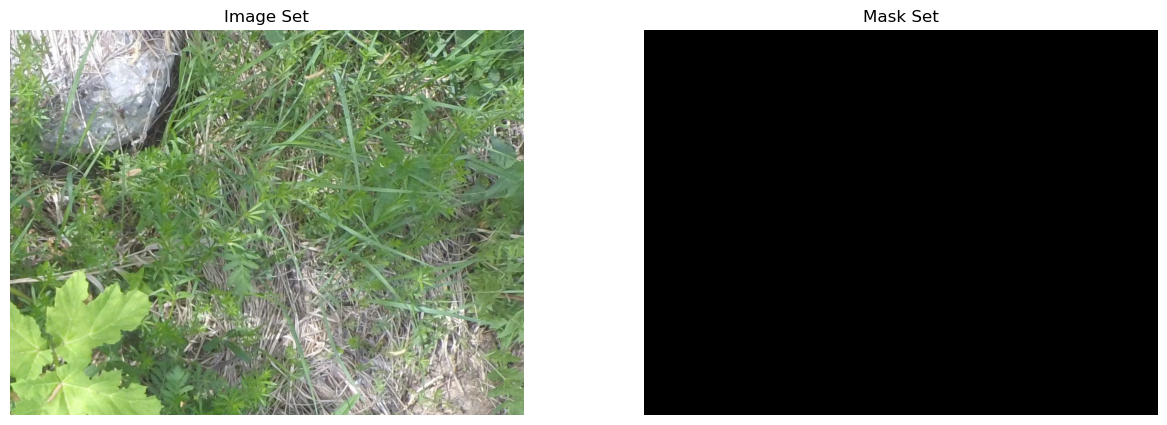

In [3]:
def toon_willekeurige_afbeeldingen_per_set(train_afbeeldingen, test_afbeeldingen):
    train_afbeelding = train_afbeeldingen[np.random.randint(len(train_afbeeldingen))]
    test_afbeelding = test_afbeeldingen[np.random.randint(len(test_afbeeldingen))]

    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    axs[0].imshow(train_afbeelding)
    axs[0].set_title("Image Set")
    axs[0].axis('off')
    axs[1].imshow(test_afbeelding)
    axs[1].set_title("Mask Set")
    axs[1].axis('off')
    plt.show()

image_map_pad = 'image_kwadranten'
image_afbeeldingen = laad_afbeeldingen(image_map_pad)

mask_map_pad = 'mask_kwadranten'
mask_afbeeldingen = laad_afbeeldingen(mask_map_pad)

display(image_afbeeldingen.shape, mask_afbeeldingen.shape)
toon_willekeurige_afbeeldingen_per_set(image_afbeeldingen, mask_afbeeldingen)

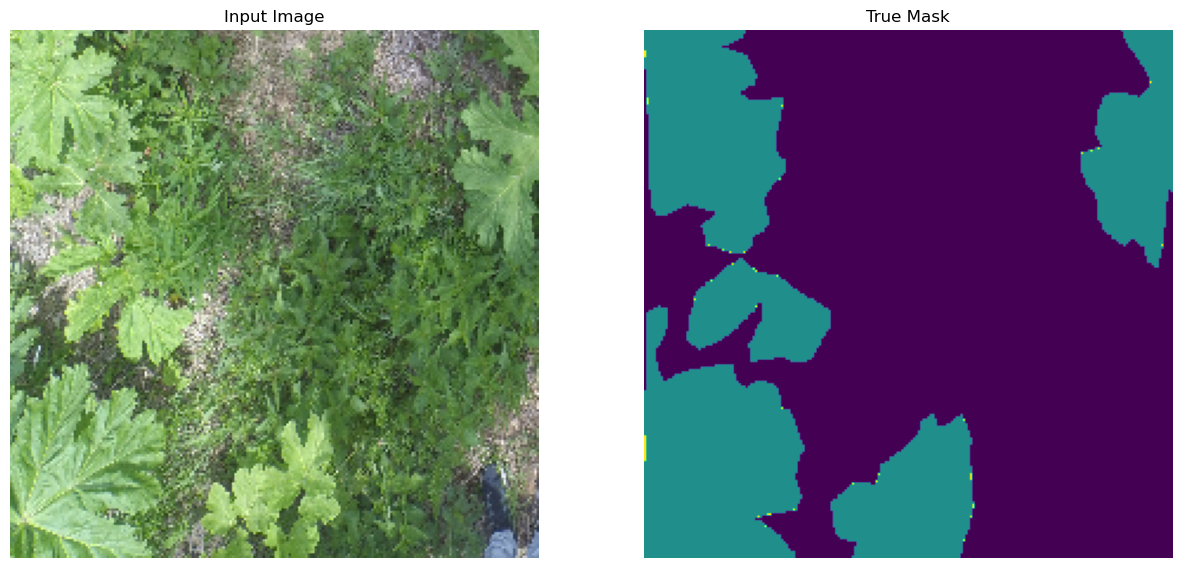

In [4]:
def load_images_and_masks(image_folder, mask_folder):
    image_filenames = os.listdir(image_folder)
    images = []
    masks = []
    for img_file in image_filenames:
        img_path = os.path.join(image_folder, img_file)
        mask_file = img_file  
        mask_path = os.path.join(mask_folder, mask_file)
        img = keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
        img_array = keras.preprocessing.image.img_to_array(img)
        mask = keras.preprocessing.image.load_img(mask_path, color_mode="grayscale", target_size=(224, 224))
        mask_array = keras.preprocessing.image.img_to_array(mask)
        images.append(img_array)
        masks.append(mask_array)
    return np.array(images), np.array(masks)

image_folder = 'image_kwadranten'
mask_folder = 'mask_kwadranten'

images, masks = load_images_and_masks(image_folder, mask_folder)
train_images, test_images, train_masks, test_masks = train_test_split(images, masks, test_size=0.2, random_state=42)

def display_images(display_list):
    plt.figure(figsize=(15, 15))
    title = ['Input Image', 'True Mask', 
            'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')

    plt.show()

sample_image, sample_mask = train_images[8], train_masks[8]
display_list = [sample_image, sample_mask]  
display_images(display_list)

In [5]:
width, height = 224, 224

base_model = keras.applications.vgg16.VGG16(
	include_top=False, input_shape=(width, height, 3))

layer_names = [
	'block1_pool',
	'block2_pool',
	'block3_pool',
	'block4_pool',
	'block5_pool',
]
base_model_outputs = [base_model.get_layer(
	name).output for name in layer_names]
base_model.trainable = False

VGG_16 = tf.keras.models.Model(base_model.input,
							base_model_outputs)

2024-03-30 13:44:58.795372: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2024-03-30 13:44:58.795411: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 18.00 GB
2024-03-30 13:44:58.795441: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 6.00 GB
2024-03-30 13:44:58.795915: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-03-30 13:44:58.795937: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [6]:
def fcn8_decoder(convs, n_classes):
    n = 4096

    c6 = tf.keras.layers.Conv2D(n, (7, 7), activation='relu', padding='same', name="conv6")(convs[-1])
    c7 = tf.keras.layers.Conv2D(n, (1, 1), activation='relu', padding='same', name="conv7")(c6)

    o = tf.keras.layers.Conv2DTranspose(n_classes, kernel_size=(4, 4), strides=(2, 2), use_bias=False)(c7)
    o = tf.keras.layers.Cropping2D(cropping=(1, 1))(o)

    o2 = tf.keras.layers.Conv2D(n_classes, (1, 1), activation='relu', padding='same')(convs[3])
    o = tf.keras.layers.Add()([o, o2])

    o = tf.keras.layers.Conv2DTranspose(n_classes, kernel_size=(4, 4), strides=(2, 2), use_bias=False)(o)
    o = tf.keras.layers.Cropping2D(cropping=(1, 1))(o)

    o2 = tf.keras.layers.Conv2D(n_classes, (1, 1), activation='relu', padding='same')(convs[2])
    o = tf.keras.layers.Add()([o, o2])

    o = tf.keras.layers.Conv2DTranspose(n_classes, kernel_size=(8, 8), strides=(8, 8), use_bias=False)(o)

    o = tf.keras.layers.Activation('softmax')(o)
    return o

In [10]:
def segmentation_model():
	inputs = keras.layers.Input(shape=(width, height, 3))
	convs = VGG_16(inputs)
	outputs = fcn8_decoder(convs, 3)
	model = tf.keras.Model(inputs=inputs, outputs=outputs)
	return model

opt = keras.optimizers.legacy.Adam()

model = segmentation_model()
model.compile(optimizer=opt,
			loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
			metrics=['accuracy'])

1/1 [==============================] - 0s 138ms/step


2024-03-30 13:45:36.337837: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


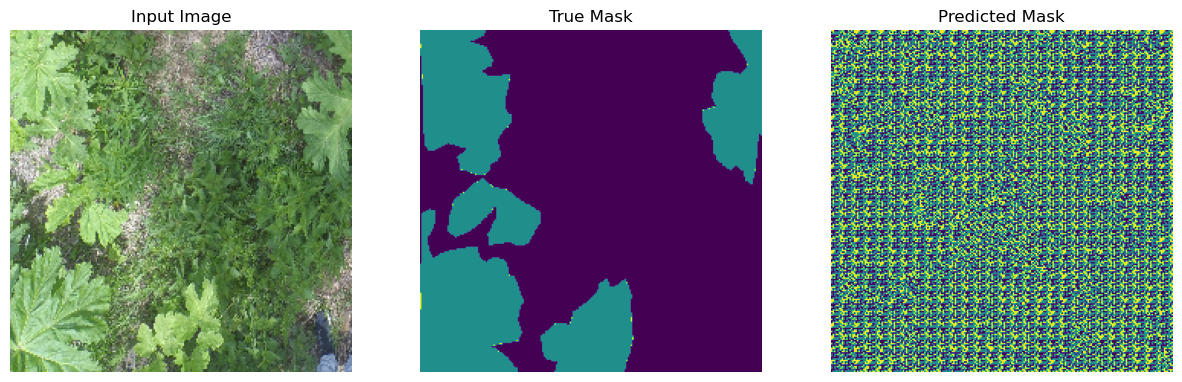

In [11]:
def create_mask(pred_mask):
	pred_mask = tf.argmax(pred_mask, axis=-1)
	pred_mask = pred_mask[..., tf.newaxis]
	return pred_mask[0]

def show_predictions(dataset=None, num=1):
	if dataset:
		for image, mask in dataset.take(num):
			pred_mask = model.predict(image)
			display_images([image[0], mask[0], create_mask(pred_mask)])
	else:
		display_images([sample_image, sample_mask,
						create_mask(model.predict(sample_image[tf.newaxis, ...]))])
show_predictions()

In [12]:
BATCH_SIZE = 32
train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_masks)).batch(BATCH_SIZE)
test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_masks)).batch(BATCH_SIZE)

model_history = model.fit(train_ds, epochs=10, validation_data=test_ds)

Epoch 1/10


/Users/vince/tensorflow-test/env/lib/python3.8/site-packages/keras/src/backend.py:5714: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
2024-03-30 13:45:40.144199: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


27/27 [==============================] - ETA: 0s - loss: 12.6499 - accuracy: 0.3575

2024-03-30 13:45:57.452078: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


27/27 [==============================] - 21s 721ms/step - loss: 12.6499 - accuracy: 0.3575 - val_loss: 1.5034 - val_accuracy: 0.4134
Epoch 2/10
27/27 [==============================] - 19s 711ms/step - loss: 1.2734 - accuracy: 0.4353 - val_loss: 1.1524 - val_accuracy: 0.4530
Epoch 3/10
27/27 [==============================] - 19s 708ms/step - loss: 1.1288 - accuracy: 0.4672 - val_loss: 1.0864 - val_accuracy: 0.4857
Epoch 4/10
27/27 [==============================] - 20s 728ms/step - loss: 1.0496 - accuracy: 0.5082 - val_loss: 0.9871 - val_accuracy: 0.5335
Epoch 5/10
27/27 [==============================] - 19s 723ms/step - loss: 0.9112 - accuracy: 0.5819 - val_loss: 0.8070 - val_accuracy: 0.6534
Epoch 6/10
27/27 [==============================] - 20s 736ms/step - loss: 0.6712 - accuracy: 0.7226 - val_loss: 0.5403 - val_accuracy: 0.7899
Epoch 7/10
27/27 [==============================] - 20s 726ms/step - loss: 0.3919 - accuracy: 0.8489 - val_loss: 0.5116 - val_accuracy: 0.8795
Epoch 8/1

In [13]:
def plot_loss_and_accuracy(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

    ax1.plot(history.history['loss'], label='Training Loss')
    ax1.plot(history.history['val_loss'], label='Validation Loss')
    ax1.set_title('Training and Validation Losses')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='Training Accuracy')
    ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax2.set_title('Training and Validation Accuracies')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()

    plt.show()

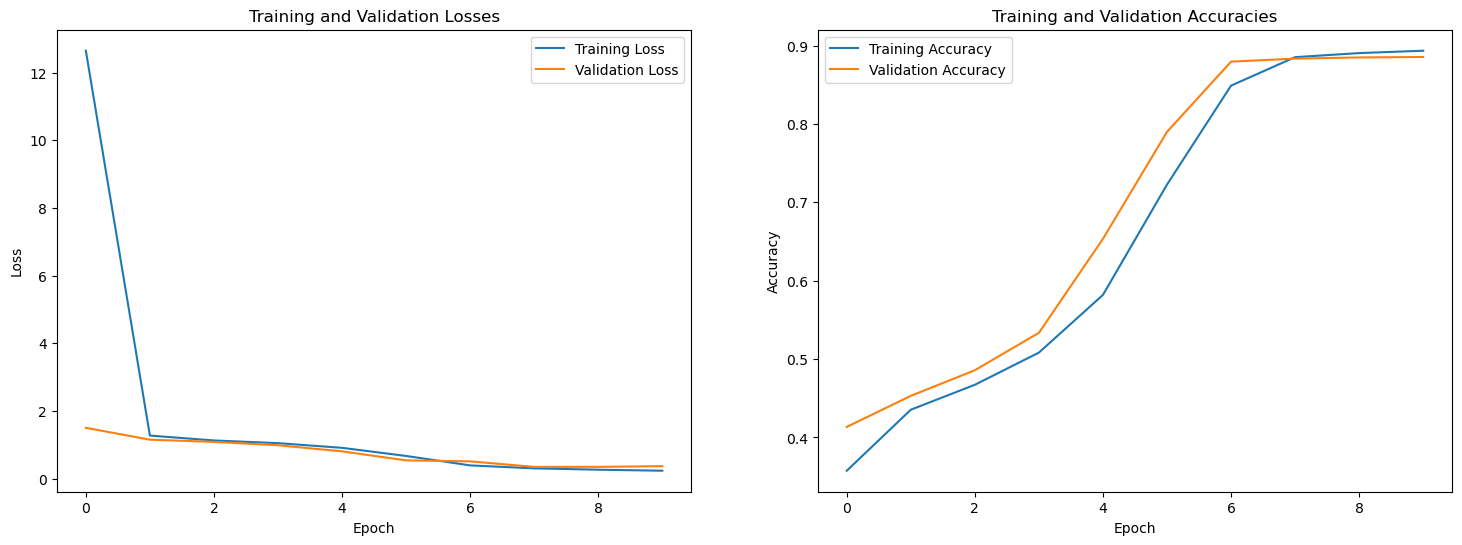

In [14]:
plot_loss_and_accuracy(model_history)

1/1 [==============================] - 0s 40ms/step


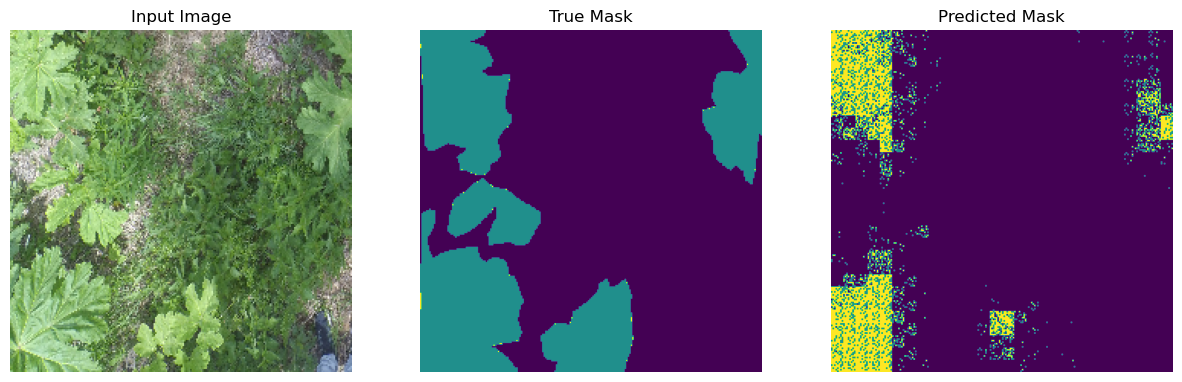

In [ ]:
show_predictions()